<a href="https://colab.research.google.com/github/GriPet12/mercorAiDetect/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install sentencepiece transformers --quiet

# Import

In [16]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Load Data

In [6]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

train['answer'] = train['answer'].astype(str)
train['topic'] = train['topic'].astype(str)
test['answer'] = test['answer'].astype(str)
test['topic'] = test['topic'].astype(str)

# Dataset Class

In [7]:
class TextDataset(Dataset):
    def __init__(self, topics, answers, labels=None):
        self.texts = [t + " [SEP] " + a for t, a in zip(topics, answers)]
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# Parameters

In [8]:
MODEL_NAME = "microsoft/deberta-v3-base"
OUTPUT_DIR = "./deberta_v3_fulltrain"
os.makedirs(OUTPUT_DIR, exist_ok=True)

MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 50
LR = 5e-7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenizer

In [9]:
tokenizer = DebertaV2Tokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

# Prepare Datasets

In [10]:
train_dataset = TextDataset(train['topic'].tolist(), train['answer'].tolist(), train['is_cheating'].tolist())
test_dataset = TextDataset(test['topic'].tolist(), test['answer'].tolist())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Model, Optimizer, Loss

In [11]:
model = DebertaV2ForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
loss_fn = torch.nn.BCEWithLogitsLoss()

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training Loop

Epoch 1/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1 done. Average Train Loss: 0.6767


Epoch 2/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2 done. Average Train Loss: 0.6688


Epoch 3/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3 done. Average Train Loss: 0.6569


Epoch 4/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 4 done. Average Train Loss: 0.6432


Epoch 5/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5 done. Average Train Loss: 0.6123


Epoch 6/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6 done. Average Train Loss: 0.5618


Epoch 7/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7 done. Average Train Loss: 0.5195


Epoch 8/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8 done. Average Train Loss: 0.4635


Epoch 9/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9 done. Average Train Loss: 0.4258


Epoch 10/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 10 done. Average Train Loss: 0.3898


Epoch 11/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 11 done. Average Train Loss: 0.3648


Epoch 12/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 12 done. Average Train Loss: 0.3320


Epoch 13/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 13 done. Average Train Loss: 0.3028


Epoch 14/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 14 done. Average Train Loss: 0.2857


Epoch 15/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 15 done. Average Train Loss: 0.2619


Epoch 16/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 16 done. Average Train Loss: 0.2436


Epoch 17/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 17 done. Average Train Loss: 0.2305


Epoch 18/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 18 done. Average Train Loss: 0.2103


Epoch 19/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 19 done. Average Train Loss: 0.1999


Epoch 20/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 20 done. Average Train Loss: 0.1867


Epoch 21/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 21 done. Average Train Loss: 0.1751


Epoch 22/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 22 done. Average Train Loss: 0.1614


Epoch 23/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 23 done. Average Train Loss: 0.1504


Epoch 24/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 24 done. Average Train Loss: 0.1412


Epoch 25/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 25 done. Average Train Loss: 0.1341


Epoch 26/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 26 done. Average Train Loss: 0.1322


Epoch 27/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 27 done. Average Train Loss: 0.1178


Epoch 28/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 28 done. Average Train Loss: 0.1128


Epoch 29/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 29 done. Average Train Loss: 0.1044


Epoch 30/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 30 done. Average Train Loss: 0.1079


Epoch 31/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 31 done. Average Train Loss: 0.0974


Epoch 32/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 32 done. Average Train Loss: 0.0949


Epoch 33/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 33 done. Average Train Loss: 0.0916


Epoch 34/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 34 done. Average Train Loss: 0.0864


Epoch 35/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 35 done. Average Train Loss: 0.0890


Epoch 36/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 36 done. Average Train Loss: 0.0834


Epoch 37/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 37 done. Average Train Loss: 0.0840


Epoch 38/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 38 done. Average Train Loss: 0.0743


Epoch 39/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 39 done. Average Train Loss: 0.0781


Epoch 40/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 40 done. Average Train Loss: 0.0752


Epoch 41/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 41 done. Average Train Loss: 0.0743


Epoch 42/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 42 done. Average Train Loss: 0.0754


Epoch 43/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 43 done. Average Train Loss: 0.0729


Epoch 44/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 44 done. Average Train Loss: 0.0623


Epoch 45/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 45 done. Average Train Loss: 0.0641


Epoch 46/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 46 done. Average Train Loss: 0.0659


Epoch 47/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 47 done. Average Train Loss: 0.0609


Epoch 48/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 48 done. Average Train Loss: 0.0621


Epoch 49/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 49 done. Average Train Loss: 0.0587


Epoch 50/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 50 done. Average Train Loss: 0.0576
✅ Final model saved to ./deberta_v3_fulltrain/final_model.pth
📊 Loss plot saved to ./deberta_v3_fulltrain/loss_plot.png


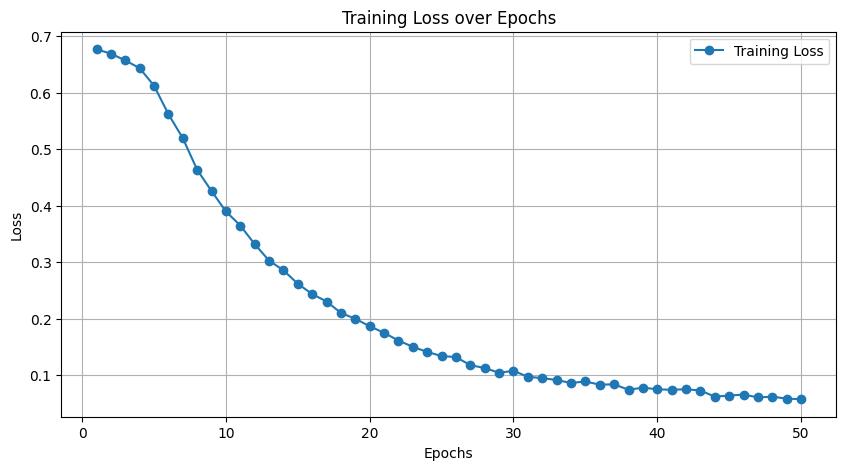

In [17]:
train_losses = []

model.train()

for epoch in range(EPOCHS):
    total_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).unsqueeze(1)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
        loss = loss_fn(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        current_loss = loss.item()
        total_loss += current_loss

        progress_bar.set_postfix({'loss': f'{current_loss:.4f}'})

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1} done. Average Train Loss: {avg_loss:.4f}")

final_model_path = os.path.join(OUTPUT_DIR, "final_model.pth")
torch.save(model.state_dict(), final_model_path)
print(f"✅ Final model saved to {final_model_path}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plot_path = os.path.join(OUTPUT_DIR, "loss_plot.png")
plt.savefig(plot_path)
print(f"📊 Loss plot saved to {plot_path}")

plt.show()

# Test Predictions

In [18]:
model.eval()
test_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting on test set"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
        test_preds.extend(torch.sigmoid(outputs).cpu().numpy())

test_preds = np.array(test_preds).flatten()

Predicting on test set:   0%|          | 0/33 [00:00<?, ?it/s]